This section goes on to read the input data and study how they are made, check the dataset size, add the necessary labels to classify, truncate the useless columns and merge the two datasets provided. 

In [35]:
import pandas as pd

# Function to read the data from a CSV file and print some information about it
def read_data(file_path):
    print("Opening dataset:", file_path)
    df = pd.read_csv(file_path)
    print("Dataframe shape:", df.shape)
    print("Dataframe columns:", df.columns)
    print("Number of missing values in each column:\n", df.isnull().sum(), "\n")
    return df

# Open CSV files
true_data = read_data("Datasets/True.csv") # True news
true_data['label'] = 1 # Add a label column to the true data

false_data = read_data("Datasets/Fake.csv") # Fake news
false_data['label'] = 0 # Add a label column to the fake data

# We actually don't need the date column for the classification
true_data.drop(columns=['date'])
false_data.drop(columns=['date'])

# Merge the two datasets
dataset = pd.concat([true_data, false_data], ignore_index=True) 

# Ignore index to reset the index
print("Dataset merged, resulting shape:", dataset.shape)

# Check if the dataset has the correct shape
assert dataset.shape[0] == true_data.shape[0] + false_data.shape[0]
assert dataset.shape[1] == true_data.shape[1] == false_data.shape[1]

Opening dataset: Datasets/True.csv
Dataframe shape: (21417, 4)
Dataframe columns: Index(['title', 'text', 'subject', 'date'], dtype='object')
Number of missing values in each column:
 title      0
text       0
subject    0
date       0
dtype: int64 

Opening dataset: Datasets/Fake.csv
Dataframe shape: (23481, 4)
Dataframe columns: Index(['title', 'text', 'subject', 'date'], dtype='object')
Number of missing values in each column:
 title      0
text       0
subject    0
date       0
dtype: int64 

Dataset merged, resulting shape: (44898, 5)


In [36]:
import string
import re
import contractions
import nltk
from nltk.corpus import stopwords

# Create a new label that has title and text
dataset['full_text'] = dataset['title'] + " " + dataset['text']

# Remove the title and text columns
dataset = dataset.drop(columns=['title', 'text', 'date', 'subject'])

# Download the stopwords from NLTK if not already downloaded
if not nltk.data.find('corpora/stopwords'):
    nltk.download('stopwords')


# Inspired by : https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/
def text_cleaner(text):
    # Lowercasing the data
    text = text.lower()

    # Removing Puncuatations
    punctuations = string.punctuation
    text = ''.join([char for char in text if char not in punctuations])

    # Removing Numbers
    # Actually, we can keep the numbers as they can be useful in the classification
    # By the way, the code for remove them is:
    # text = re.sub('[0-9]+', '', text)

    # Removing extra space
    text = re.sub(' +', ' ', text)

    # Replacing the repetitions of punctations
    text = re.sub(r'([!?,.])\1+', r'\1', text)

    # Removing Emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Removing emoticons
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)

    # Removing Contractions
    text = contractions.fix(text)

    # Removing URLs
    text = re.sub(r'http\S+', '', text)

    # Removing stopwords
    # We can use the stopwords from NLTK
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Clean the text
dataset['full_text'] = dataset['full_text'].apply(text_cleaner)

# Save the dataset
dataset.to_csv("Datasets/News.csv", index=False)

print("Dataset saved to 'Datasets/News.csv'")

<>:42: SyntaxWarning: invalid escape sequence '\)'
<>:42: SyntaxWarning: invalid escape sequence '\)'
C:\Users\mannu\AppData\Local\Temp\ipykernel_4484\1555872318.py:42: SyntaxWarning: invalid escape sequence '\)'
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


Dataset saved to 'Datasets/News.csv'


This section goes on to split the data into training and testing data using the according functions from sklearn. The CountVectorizer is then used to convert the text data into numerical data that can be used for the classification, using the fit_transform function.

In [38]:
# Test train data split and import CountVectorizer to implement Bag of Words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Split the dataset into training and testing data
X_train,X_test,y_train,y_test=train_test_split(dataset.full_text,dataset.label,test_size=.2,random_state=1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# Initialize the CountVectorizer, which will convert the text data into a matrix of token counts
cv=CountVectorizer()

# Fitting the classifier to the training data
x_train_cv = cv.fit_transform(X_train)
x_test_cv = cv.transform(X_test)
predictions_list = [] # List to store the future predictions
classifier_name_list = [] # List to store the classifier names

X_train shape:  (35918,)
X_test shape:  (8980,)


The next few sections will use various Classifier to predict the test values that have been splitted from the dataset. They are predicted using the CountVectorizer that have been fitted to the training data. Then the predictions are appended to a list to be used for plotting various analysis.

In [39]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf=RandomForestClassifier()
rf.fit(x_train_cv,y_train)
y_pred_randomForest=rf.predict(x_test_cv)

predictions_list.append(y_pred_randomForest)
classifier_name_list.append("Random Forest Classifier")

In [40]:
# Using KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_cv,y_train)
y_pred_knn=knn.predict(x_test_cv)

predictions_list.append(y_pred_knn)
classifier_name_list.append("KNN Classifier")

In [41]:
# Using Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train_cv, y_train)
y_pred_log_reg = log_reg.predict(x_test_cv)

predictions_list.append(y_pred_log_reg)
classifier_name_list.append("Logistic Regression")

In [6]:
# Using Support Vector Machine
from sklearn.svm import SVC

supvm  = SVC()
# supvm.fit(x_train_cv, y_train)
# y_pred_supvm = supvm.predict(x_test_cv)

# predictions_list.append(y_pred_supvm)
# classifier_name_list.append("Support Vector Machine")

In [7]:
#Using Gaussian Classifier
"""
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train_cv.toarray(), y_train)
y_pred_gnb = gnb.predict(x_test_cv.toarray())

predictions_list.append(y_pred_gnb)
classifier_name_list.append("Gaussian Classifier")
"""

'\nfrom sklearn.naive_bayes import GaussianNB\n\ngnb = GaussianNB()\ngnb.fit(x_train_cv.toarray(), y_train)\ny_pred_gnb = gnb.predict(x_test_cv.toarray())\n\npredictions_list.append(y_pred_gnb)\nclassifier_name_list.append("Gaussian Classifier")\n'

This section implements plotting and classification report for each classifier that was used in the predictions_list, which contains the predictions for each classifier using the test data set. The classification report shows the precision, recall, f1-score and support for each class. The accuracy is also shown. The confusion matrix shows the true positive, false positive, true negative and false negative values. The ROC curve shows the true positive rate against the false positive rate. The AUC (Area Under the Curve) is also shown.

Now showing results for Random Forest Classifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4678
           1       0.99      0.99      0.99      4302

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

0.9883073496659243


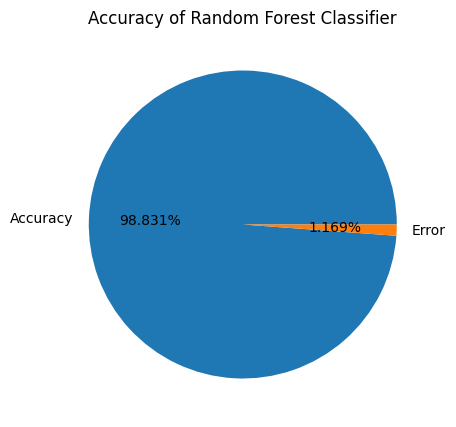

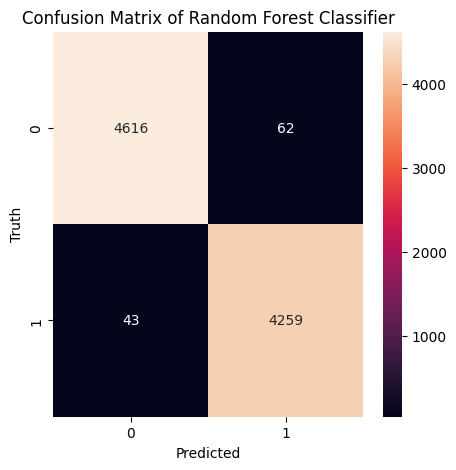

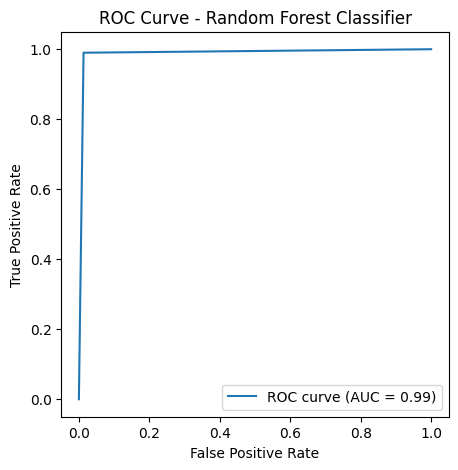

Now showing results for KNN Classifier
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      4678
           1       0.80      0.72      0.76      4302

    accuracy                           0.78      8980
   macro avg       0.79      0.78      0.78      8980
weighted avg       0.78      0.78      0.78      8980

0.7826280623608017


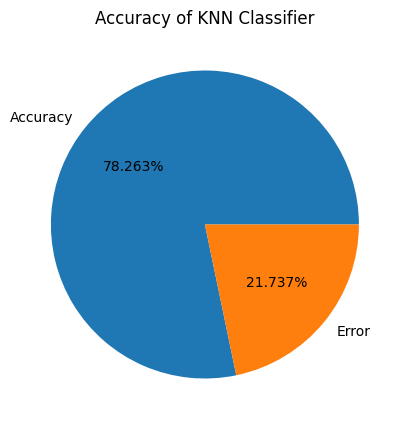

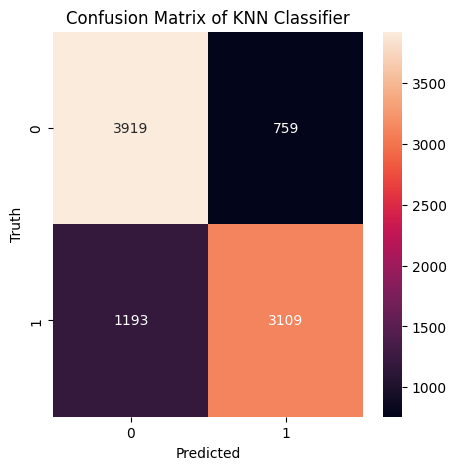

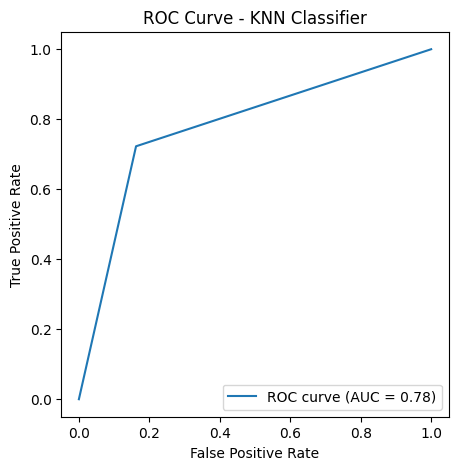

Now showing results for Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4678
           1       1.00      1.00      1.00      4302

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

0.9967706013363029


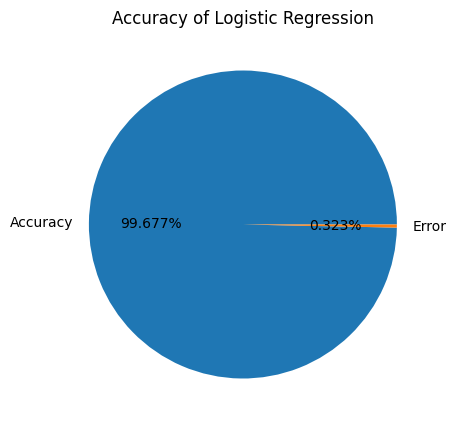

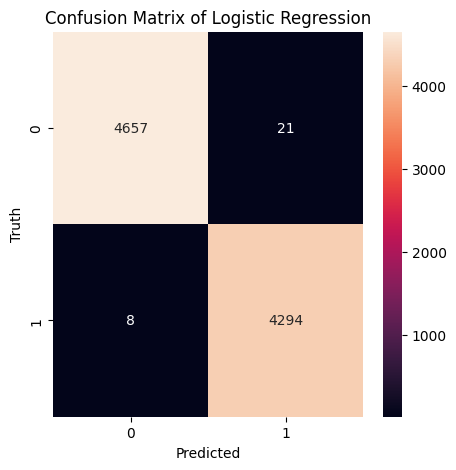

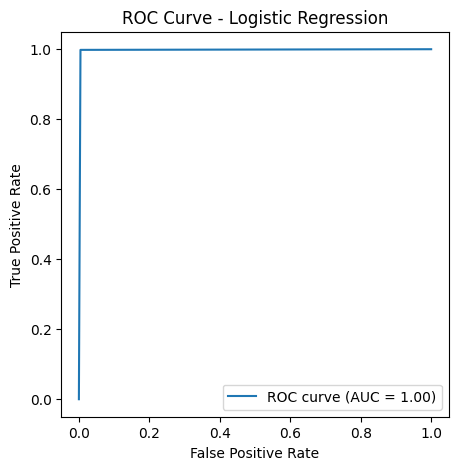

In [42]:
# Plotting the accuracy of the model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

# Function to plot the accuracy of the model
def plot_accuracy(y_test,y_pred,classifier_name):
    print(accuracy_score(y_test,y_pred))
    plt.figure(figsize=(5,5))
    plt.title('Accuracy of ' + classifier_name)
    plt.pie([accuracy_score(y_test,y_pred),1-accuracy_score(y_test,y_pred)],labels=['Accuracy','Error'],autopct='%1.3f%%')
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_test,y_pred,classifier_name):
    plt.figure(figsize=(5,5))
    plt.title('Confusion Matrix of ' + classifier_name)
    cm=confusion_matrix(y_test,y_pred)
    sns.heatmap(cm,annot=True,fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

# Function to plot the ROC AUC curve
def plot_roc_auc_curve(y_test, y_pred, classifier_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred) # Calculate the FPR and TPR
    auc = roc_auc_score(y_test, y_pred) # Calculate the AUC
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + classifier_name)
    plt.legend(loc="lower right")
    plt.show()

# Print the classification report and plot the accuracy, 
# confusion matrix and ROC AUC curve for each classifier
for index, y_pred in enumerate(predictions_list):
    print("Now showing results for",classifier_name_list[index])
    print(classification_report(y_test, y_pred))
    plot_accuracy(y_test, y_pred,classifier_name_list[index])
    plot_confusion_matrix(y_test, y_pred,classifier_name_list[index])
    plot_roc_auc_curve(y_test, y_pred, classifier_name_list[index])

In [44]:
# Loading external articles to test the model

def load_articles(file_path):
    articles = []
    with open(file_path, 'r', encoding="utf8") as file:
        for line in file:
            articles.append(line)
    return articles

#In this dataset, the articles with an even index are true, the ones with an odd index are fake

articles = load_articles("externalArticles.cvs")

In [45]:
# Input a news article to test the model

def test_news_input(text, classifier):
    news_cv = cv.transform([text])
    return classifier.predict(news_cv)

predicted_label = test_news_input(articles[0], rf)
print("The news article is: ", "True" if predicted_label else "Fake")

The news article is:  True


Now showing results for Random Forest Classifier
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

0.75


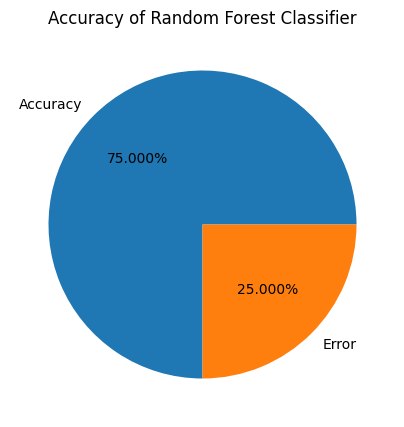

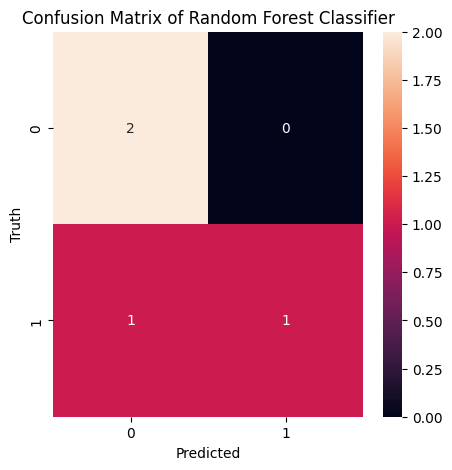

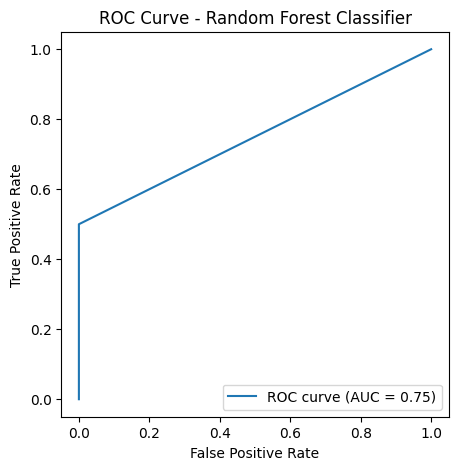

Now showing results for KNN Classifier
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

0.75


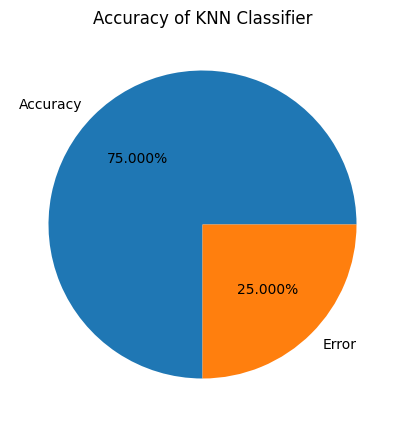

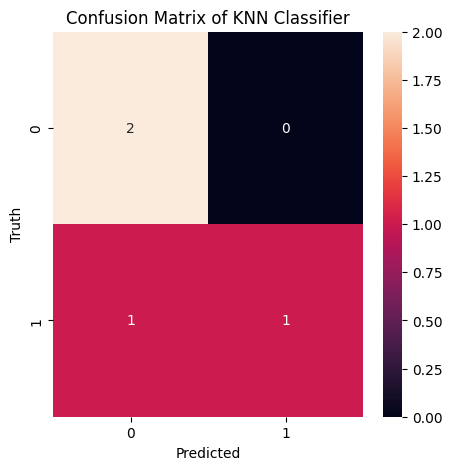

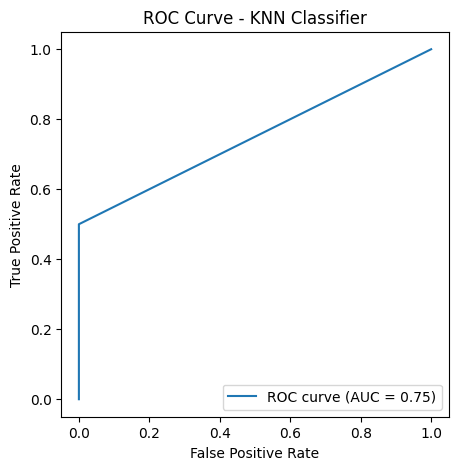

Now showing results for Logistic Regression
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

0.75


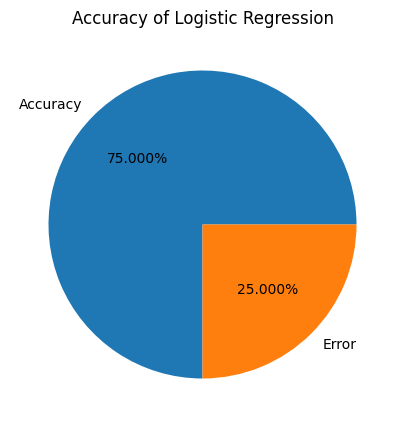

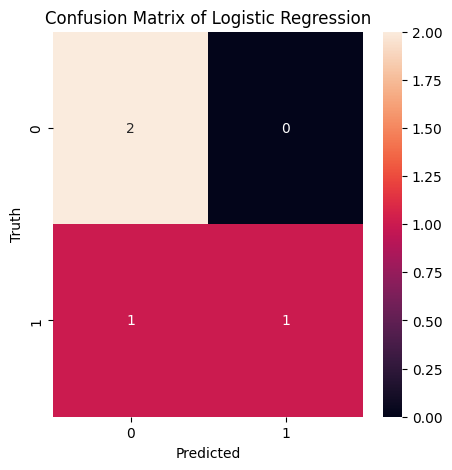

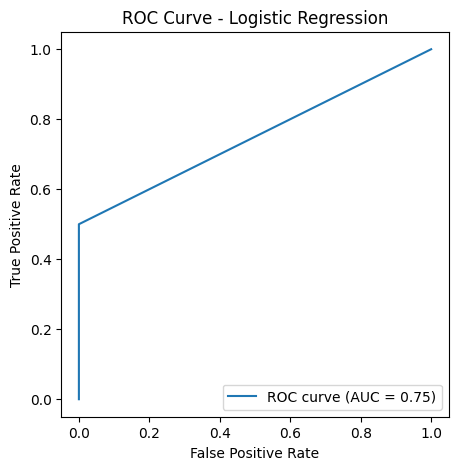

In [46]:
#Plotting external articles accuracy, confusion matrix and ROC AUC curve
def test_and_pred_for_exteranl_articles(classifier):
    y_test = []
    y_pred = []
    for i in range(len(articles)):
        y_test.append((i+1) % 2)
        y_pred.append(test_news_input(articles[i], classifier))
    return y_test, y_pred

# Print the classification report and plot the accuracy, 
# confusion matrix and ROC AUC curve for each classifier
for index, y_pred in enumerate(predictions_list):
    y_test, y_pred = test_and_pred_for_exteranl_articles(rf)
    print("Now showing results for",classifier_name_list[index])
    print(classification_report(y_test, y_pred))
    plot_accuracy(y_test, y_pred,classifier_name_list[index])
    plot_confusion_matrix(y_test, y_pred,classifier_name_list[index])
    plot_roc_auc_curve(y_test, y_pred, classifier_name_list[index])